In [1]:
# 상위 폴더 경로 가져오기.
from example_base import GetParentPath
# 핑퐁 로봇 제어 모듈 import.
from pingpongthread import PingPongThread

In [2]:
# 2개 로봇을 연결하는 인스턴스 생성.
PingPongThreadInstance = PingPongThread(number=2, group_id=4)
# 로봇 제어 쓰레드 시작.
PingPongThreadInstance.start()
# 모든 로봇이 연결될 때 까지 기다림.
PingPongThreadInstance.wait_until_full_connect()

Found device: nRF Connect USB CDC ACM(COM12)
Serial connected.Write data:
 FF FF 04 FF 20 00 AD 00 0B 1A 04
Connected with a master robot.
Connected robots: 2
Fully connected.


In [3]:
# 큐브 ID
cube_ID = 1

In [4]:
# '일반 쓰레기' 사진 클래스 인스턴스, '재활용 쓰레기' 클래스 인스턴스 생성.
general = PingPongThreadInstance.ImageClass("general", "chapter5/general")
recycle = PingPongThreadInstance.ImageClass("recycle", "chapter5/recycle")

In [5]:
# 모델 학습. 
# 첫 번째 인수는 저장하는 이름, 두 번째 인수는 knn 알고리즘의 k 값, 세 번째 인수는 모델 모드. 네 번째 인수 이후는 클래스 인스턴스들.
model = PingPongThreadInstance.train_classes("chapter5/waste_model.json", 1, 2, general, recycle)

Class general : 10 images.
Class recycle : 10 images.
Training done.
chapter5/waste_model.json saved.


In [6]:
# 센서 값 받기. 0.5초마다 한 번씩 수신.
PingPongThreadInstance.receive_sensor_data(cube_ID, method="periodic", period=0.5)

Write data: FF FF 04 00 00 C8 B8 00 0B 32 01


In [ ]:
# 근접 센서의 디폴트 값 받기. 이 함수를 실행할 때는 근접 센서 앞에 아무것도 없도록 주의.
proxy_default = PingPongThreadInstance.get_default_proxy(cube_ID)

In [ ]:
# 시간 제어를 위한 모듈 import.
import time

# 근접 센서를 체크하는 루프.
while True:
    # 근접 센서 변화량.
    proxy_diff = abs(PingPongThreadInstance.get_current_proxy(cube_ID) - proxy_default)
    # 근접 센서 변화량이 10을 넘으면 쓰레기 검사. 
    if 10 < proxy_diff:
        print("장애물이 감지되었어요.")
        # 센서 데이터 그만 받기.
        PingPongThreadInstance.stop_sensor_data(cube_ID) 
        print("안녕하세요? 생활에서 중요한 재활용 분리수거. 제가 도와드릴게요!")
        time.sleep(4)
        print("이미지를 보여주세요.")
        time.sleep(2)
        break
    else:
        print("장애물이 감지되지 않았어요.")
        time.sleep(0.1)
        # 출력 비우기.
        PingPongThreadInstance.clear_output()

In [6]:
# 웹캠 열기.
# PingPongThreadInstance.webcam_open(0)
PingPongThreadInstance.webcam_open("http://192.168.66.1:9527/videostream.cgi?loginuse=admin&loginpas=admin")

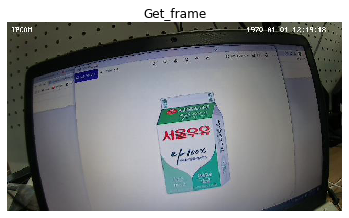

{'general': 0, 'recycle': 1}
accum_prediction: {'recycle': 1.0}
재활용 쓰레기
Write data: FF FF 04 AA 20 00 CD 00 20 02 01 00 00 FF FF 04 00 20 00 C1 00 13 02 01 00 02 03 84 00 00 01 F4
Aggregator set.
Write data: FF FF 04 AA 20 00 CD 00 20 02 01 00 00 FF FF 04 00 20 00 C1 00 13 02 01 00 02 FC 7C 00 00 01 F4
Aggregator set.
더 버릴 쓰레기가 있으신가요? (있으면 1 아니면 0): 0
분리수거를 생활화합시다!


In [7]:
import time

# 프레임을 평가하는 인스턴스 생성. 누적 프레임은 5초 동안 보관.
frames_predictor = PingPongThreadInstance.FramesPredictor(model=model, timer_sec=3)
# KNN 알고리즘의 k를 1로 설정.
frames_predictor.set_knn_k(1)
# 웹캠을 이용하여 쓰레기 분류를 예측하는 루프.
while True:
    # 주피터 노트북 출력 비우기.
    PingPongThreadInstance.clear_output()
    # 현재 웹캠 프레임을 보여주고 가져오기.
    frame = PingPongThreadInstance.webcam_get_frame(window="Get_frame")
    # 현재 프레임을 평가하고, 평가 내용을 누적.
    frame_prediction = frames_predictor.image_predict_and_accum(frame)
    print(frame_prediction)
    # 누적된 평가 내용.
    accum_prediction = frames_predictor.accum_predict()
    # 누적된 평가 내용이 없으면 돌아가기. 아니면 가장 확률이 높은 클래스 확인.
    if accum_prediction == None:
        max_class = None
        continue
    else:
        print("accum_prediction:", accum_prediction)
        # 가장 확률이 높은 클래스.
        max_class = max(accum_prediction, key=accum_prediction.get)
    # 일반 쓰레기일 확률이 90% 이상이면 왼쪽을 가리킴.
    if max_class == "general" and accum_prediction[max_class] > 0.9:
        print("일반쓰레기")
        # 5초 쉼.
        time.sleep(5)
        # 15RPM, 시계 반대 방향으로 1/4바퀴(90도) 회전.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, -0.25)
        # 2초 쉼.
        time.sleep(2)
        # 15RPM, 시계 방향으로 1/4바퀴(90도) 회전.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, 0.25)
        # 1초 쉼.
        time.sleep(1)
    # 재활용 쓰레기일 확률이 90% 이상이면 오른쪽을 가리킴.
    elif max_class == "recycle" and accum_prediction[max_class] > 0.9:
        print("재활용 쓰레기")
        # 5초 쉼.
        time.sleep(5)
        # 15RPM, 시계 방향으로 1/4바퀴(90도) 회전.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, 0.25)
        # 2초 쉼.
        time.sleep(2)
        # 15RPM, 시계 반대 방향으로 1/4바퀴(90도) 회전.
        PingPongThreadInstance.run_motor_step(cube_ID, 15, -0.25)
        # 1초 쉼.
        time.sleep(1)
    # 모두 아니면 돌아가기.
    else:
        continue
    # 입력 값 받기. 1이면 다시 이미지를 인식하고, 나머지면 종료.
    text = "더 버릴 쓰레기가 있으신가요? (있으면 1 아니면 0): "
    x = input(text)
    if x == "1":
        print("이미지를 보여주세요!")
        # 누적된 프레임 비우기.
        frames_predictor.clear_accum()
        time.sleep(2)
        continue
    else:
        print("분리수거를 생활화합시다!")
        break

In [ ]:
# 웹캠 닫기.
PingPongThreadInstance.webcam_close()
# 로봇 제어 쓰레드 종료.
PingPongThreadInstance.end()